In [0]:
!pip install tensorflow --upgrade

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 55.7MB/s 
     |████████████████████████████████| 3.9MB 27.0MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import layers,models,optimizers,utils
import numpy as np
import matplotlib.pyplot as plt


In [0]:
(train_data, train_targets), (test_data,test_targets)=boston_housing.load_data()
print(train_data.shape)
print(test_data.shape)
print(train_targets)

57344/57026 [==============================] - 0s 0us/step
(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 3

In [0]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [0]:
train_targets[0]

15.2

In [0]:
#Normalizing Data
mean = train_data.mean(axis=0)
train_data -=mean
std=train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [0]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [0]:
#Kfold Validation
k = 4
num_val_samples = len(train_data)//4
num_of_epochs = 100
all_score = []
all_mae_histories=[]
for i in range(k):
    print('processing fold #', i)
    #-validation data: data from partition k=4
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]  
    #-training data: data from all other partitions
    partial_train_data = np.concatenate(
                        [train_data[:i*num_val_samples],
                         train_data[(i+1)*num_val_samples:]],
                        axis=0)
    
    partial_train_targets = np.concatenate(
                            [train_targets[:i*num_val_samples],
                             train_targets[(i+1)*num_val_samples:]],
                            axis=0)
    model = build_model()
    history=model.fit(partial_train_data, partial_train_targets, epochs=100, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_score.append(val_mae)
    mae_history= history.history['mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
#error
average_mae_history= [np.mean([x[i] for x in all_mae_histories]) for i in range(num_of_epochs)]
print('All fold validation errors: ', all_score)
print('Mean of All fold validation errors: ', np.mean(all_score))
print('Average mae history: ', average_mae_history)

All fold validation errors:  [1.9046258, 2.416511, 2.947326, 2.4998815]
Mean of All fold validation errors:  2.4420862
Average mae history:  [10.830303, 3.6908243, 3.0629158, 2.788352, 2.6144714, 2.4769087, 2.3936658, 2.3534462, 2.274388, 2.2268696, 2.167002, 2.190326, 2.1168046, 2.0801353, 2.0783954, 2.0597124, 2.0302894, 2.0044317, 1.9763759, 1.9746047, 1.9357309, 1.9600481, 1.9283979, 1.9198332, 1.8846776, 1.8660694, 1.8206339, 1.8130103, 1.823736, 1.7855299, 1.8454392, 1.78284, 1.7782404, 1.7686617, 1.7250639, 1.7579488, 1.7262163, 1.7043902, 1.7093232, 1.6761637, 1.665417, 1.6564415, 1.672468, 1.6533295, 1.6255761, 1.6365182, 1.6553241, 1.614327, 1.5918331, 1.5695777, 1.5789518, 1.5908363, 1.5941274, 1.5710517, 1.5779881, 1.5403095, 1.5383219, 1.5347767, 1.5044377, 1.5160863, 1.5276773, 1.513943, 1.484623, 1.4879946, 1.477751, 1.515131, 1.4853808, 1.4694505, 1.4304754, 1.4528736, 1.4586642, 1.4477789, 1.4175391, 1.4385417, 1.4141489, 1.4209787, 1.4295835, 1.3997201, 1.3839078, 1.4

In [0]:
[len(x) for x in all_mae_histories]

[100, 100, 100, 100]

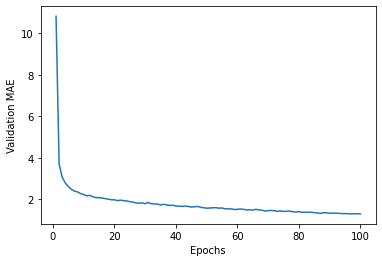

In [0]:
#plotting error
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

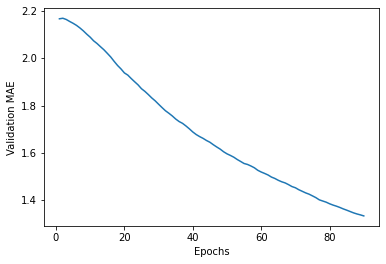

In [0]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [0]:
#Training and Testing Final Model
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

Train on 404 samples
Epoch 1/80
404/404 [==============================] - 0s 1ms/sample - loss: 460.5906 - mae: 19.2167
Epoch 2/80
404/404 [==============================] - 0s 93us/sample - loss: 273.3130 - mae: 14.0772
Epoch 3/80
404/404 [==============================] - 0s 91us/sample - loss: 110.5009 - mae: 8.3509
Epoch 4/80
404/404 [==============================] - 0s 101us/sample - loss: 43.6517 - mae: 4.9183
Epoch 5/80
404/404 [==============================] - 0s 98us/sample - loss: 28.7947 - mae: 3.8363
Epoch 6/80
404/404 [==============================] - 0s 91us/sample - loss: 22.8878 - mae: 3.3959
Epoch 7/80
404/404 [==============================] - 0s 102us/sample - loss: 19.4871 - mae: 3.1843
Epoch 8/80
404/404 [==============================] - 0s 93us/sample - loss: 16.9733 - mae: 2.9050
Epoch 9/80
404/404 [==============================] - 0s 95us/sample - loss: 15.8219 - mae: 2.8134
Epoch 10/80
404/404 [==============================] - 0s 100us/sample - loss: 14.